# Spearman correlation matrix
鉴于多组学数据的非正态分布及 CNV 的离散特性，本研究采用 Spearman 秩相关系数构建特征网络，该策略得到了近期四篇关键文献的直接支持：首先，理论研究 "Effects of Spearman's and Pearson's correlations on construction of cancer regulatory networks and biomarker selection" (2025) 证实了 Spearman 在构建癌症调控网络时对非线性关系和离群值的鲁棒性显著优于 Pearson；其次，基准测试 "scCoBench: Benchmarking single cell RNA-seq co-expression using promoter-reporter lines" (2025) 验证了其在处理高稀疏度生物数据时的准确性；在应用层面，"Integrative multi-omics analysis reveals a novel subtype of hepatocellular carcinoma with biological and clinical relevance" (2024) 确立了利用 Spearman 筛选特征进行癌症亚型识别的标准流程，而 "Integrative analysis of lactylation related genes in prostate cancer: unveiling heterogeneity through single-cell RNA-seq" (2025) 则进一步实证了其在整合离散 CNV 与连续 mRNA 混合数据时的有效性与通用性。

In [ ]:
import pandas as pd
import os

INPUT_FILE = "../mRMR/Final_Forced_MultiOmics_Signature_Renamed.csv"
OUTPUT_FILE = "702_raw_data_forrelation.csv"  

cg_to_name_map = {
    "cg22678977": "LRRC6",
    "cg27169860": "chr2 66218712 LINC02934 (29533)",
    "cg09000583": "HOXB13",
    "cg20415486": "chr10 3949206 LINC02660 (4871)",
    "cg17627629": "chr5 179517140 RNF130 (18026)",
    "cg04557423": "LOC727677",
    "cg03387103": "LETM1",
    "cg02003183": "CDC42BPB",
    "cg02693150": "C8orf38",
    "cg11197206": "chr14 100504766 EVL (18852)",
    "cg15690342": "chr5 72594851 LOC340090 (24088)",
    "cg18948877": "chr2 242904738 LINC01238 (3421)",
    "cg20456954": "ARFGEF1",
    "cg12633764": "MAPT",
    "cg25245963": "ZFAT",
    "cg11386025": "KCNQ4",
    "cg22789237": "chr1 232684368 SIPA1L2 (12934)",
    "cg03103549": "CRNKL1",
    "cg06436185": "PRKAG2",
    "cg25787812": "MICB"
}


name_to_cg_map = {v: k for k, v in cg_to_name_map.items()}

def main():
    df = pd.read_csv(INPUT_FILE)

    new_columns = {}
    renamed_count = 0
    
    for col in df.columns:
        if col.startswith("Methylation_"):
            current_suffix = col.replace("Methylation_", "")
            if current_suffix in name_to_cg_map:
                cg_id = name_to_cg_map[current_suffix]
                # 生成新列名: Methylation_cgXXXX
                new_col_name = f"Methylation_{cg_id}"
                new_columns[col] = new_col_name
                renamed_count += 1
            else:
                new_columns[col] = col
        else:
            new_columns[col] = col
    

    df_restored = df.rename(columns = new_columns)
    df_restored.to_csv(OUTPUT_FILE, index = False)
if __name__ == "__main__":
    main()

# Spearman Correaltion Matrix

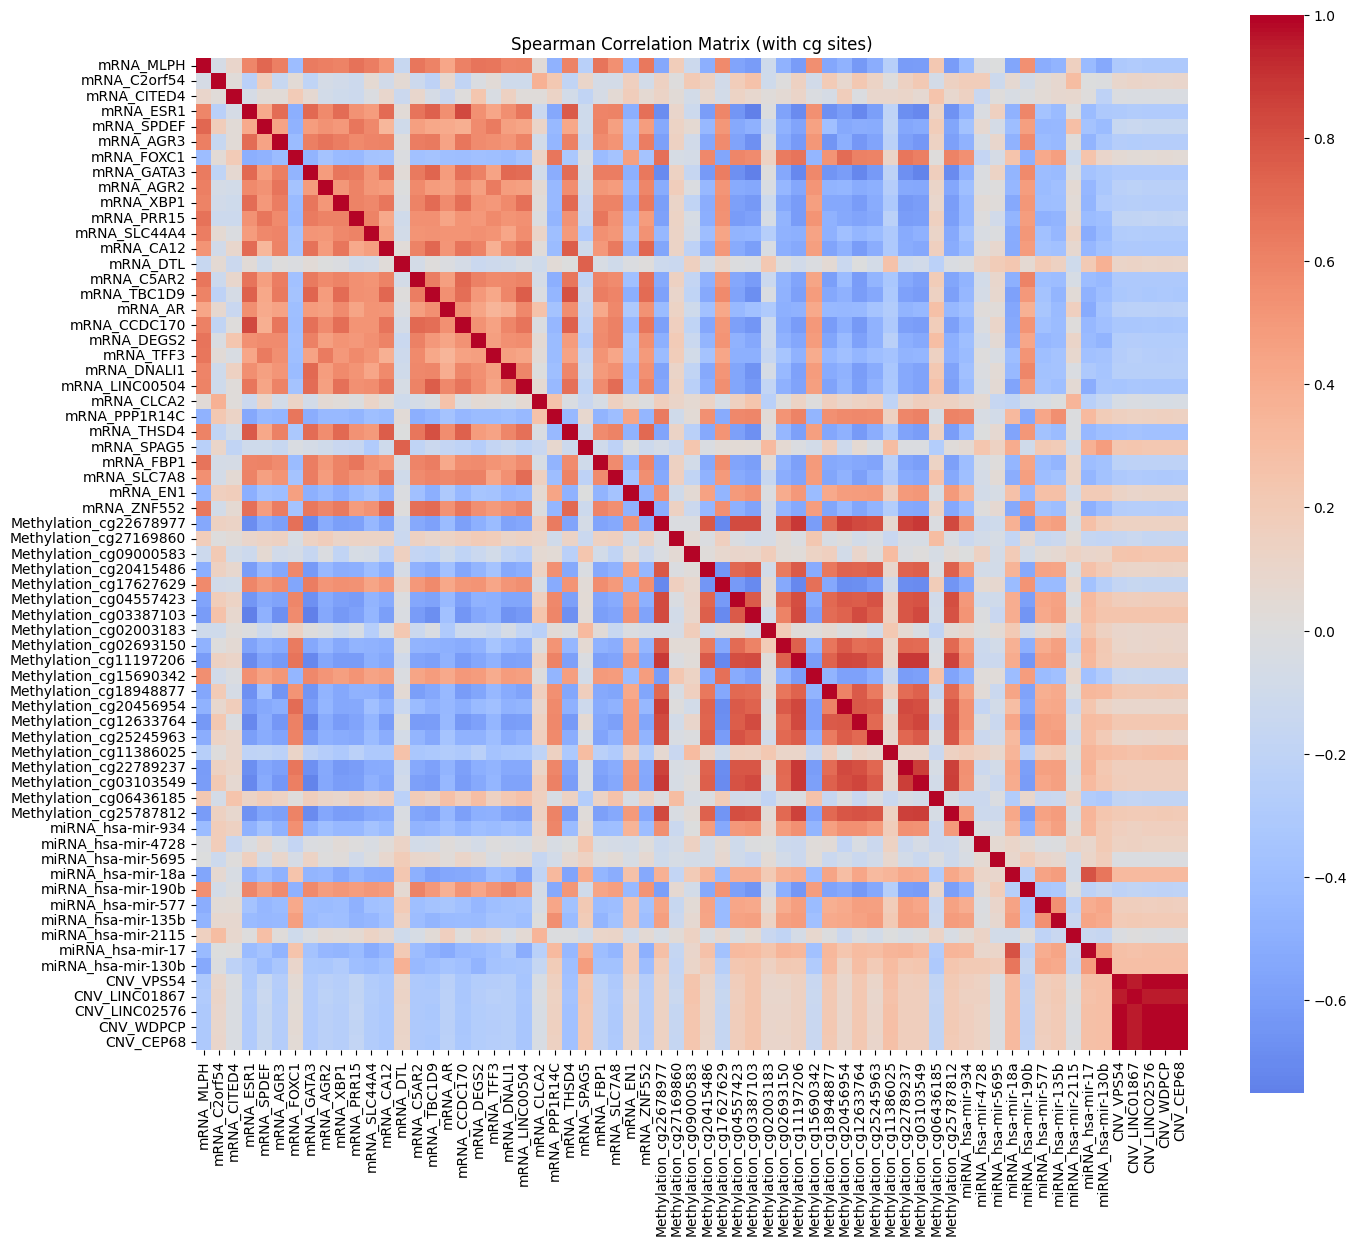

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


input_file = "702_raw_data_forrelation.csv"
df = pd.read_csv(input_file)

if 'PatientID' in df.columns:
    df = df.drop(columns = ['PatientID'])

corr_matrix = df.corr(method = 'spearman')

output_csv = "Spearman_Correlation_Matrix.csv"
corr_matrix.to_csv(output_csv)

plt.figure(figsize = (16, 14))
sns.heatmap(corr_matrix, cmap = 'coolwarm', center = 0, square = True)
plt.title("Spearman Correlation Matrix (with cg sites)")
plt.savefig("Spearman_Matrix_Heatmap.png")


# Thershold filter
"Correlation network of levels of expression of circadian genes": We defined network edges using a Spearman correlation threshold of 0.3, a cutoff validated in this study to capture meaningful regulatory connections.

In [5]:
import pandas as pd
import numpy as np


INPUT_MATRIX = "Spearman_Correlation_Matrix.csv" 
OUTPUT_FILE = "RAG_Task_List_Threshold_0.3.csv"      
THRESHOLD = 0.3                                        

def get_rag_name(col_name):
    if col_name.startswith("mRNA_"):
        return f"gene {col_name.replace('mRNA_', '')}"
    elif col_name.startswith("miRNA_"):
        return f"microRNA {col_name.replace('miRNA_', '')}"
    elif col_name.startswith("CNV_"):
        return f"CNV of {col_name.replace('CNV_', '')}"
    elif col_name.startswith("Methylation_"):
        return f"CpG site {col_name.replace('Methylation_', '')}" 
    return col_name

def main():
    df = pd.read_csv(INPUT_MATRIX, index_col=0)
    edges = []
    cols = df.columns

    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            node_a = cols[i]
            node_b = cols[j]
            r_val = df.iloc[i, j]
            
            if abs(r_val) > THRESHOLD:
                term_a = get_rag_name(node_a)
                term_b = get_rag_name(node_b)
                relation = "positive" if r_val > 0 else "negative"
                
                prompt = (
                    f"Context: Breast Cancer (BRCA) multi-omics analysis. "
                    f"Data: Strong {relation} correlation (r={r_val:.2f}) between {term_a} and {term_b}. "
                    f"Task: Verify this interaction using biomedical literature. "
                    f"Constraint 1: If valid, provide ONE concise declarative sentence describing the regulation mechanism. "
                    f"Constraint 2: You MUST append a supporting PubMed ID (PMID). "
                    f"Format: '[Mechanism Description]. [PMID: 12345678]' "
                    f"If no direct evidence exists, output ONLY: 'No evidence found.'"
                )
                
                edges.append({
                    'Source': node_a,
                    'Target': node_b,
                    'Weight': r_val,
                    'Abs_Weight': abs(r_val),
                    'RAG_Prompt': prompt
                })
    
    res_df = pd.DataFrame(edges).sort_values('Abs_Weight', ascending = False)
    res_df.to_csv(OUTPUT_FILE, index = False)

if __name__ == "__main__":
    main()

# RAG 